# Object tracking using Bayesian Tracker

This notebook shows how to previously localised and classified objects from a series of mask images and unite them over time using Bayesian multi-object tracking (btrack). 

The sections of this notebook are as follows:

1. Load segmentation objects and filter based on size
2. Run btrack, uniting the objects locations over time
3. Batch process

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

In [1]:
import btrack
from tqdm import tqdm
import os
import glob

## 1. Load segmentation objects

In [2]:
expt = 'ND0022'
pos = 'Pos12'
root_dir = '/home/nathan/data/kraken/ras/'

In [31]:
with btrack.dataio.HDF5FileHandler(
     f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_1',
) as hdf:
    objects_gfp = hdf.objects
with btrack.dataio.HDF5FileHandler(
     f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_2',
) as hdf:
    objects_rfp = hdf.objects

[INFO][2022/03/30 06:28:45 PM] Opening HDF file: /home/nathan/data/kraken/ras//ND0022/Pos12/objects.h5...
[INFO][2022/03/30 06:28:45 PM] Loading objects/obj_type_1 (386145, 5) (386145 filtered: None)
[INFO][2022/03/30 06:28:51 PM] Closing HDF file: /home/nathan/data/kraken/ras//ND0022/Pos12/objects.h5
[INFO][2022/03/30 06:28:51 PM] Opening HDF file: /home/nathan/data/kraken/ras//ND0022/Pos12/objects.h5...
[INFO][2022/03/30 06:28:51 PM] Loading objects/obj_type_2 (38765, 5) (38765 filtered: None)
[INFO][2022/03/30 06:28:52 PM] Closing HDF file: /home/nathan/data/kraken/ras//ND0022/Pos12/objects.h5


Check objects feature classification

In [39]:
objects_gfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,0,160.435898,4.226496,0.0,0,False,0,0,0.0,234.0,1.0,2.379132e-11,9.544462e-10,1.0,1.602896e-10,1.944189e-10


In [38]:
objects_rfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,0,1377.099976,10.2,0.0,0,False,0,4,0.0,10.0,2.0,0.000172,0.992246,0.006708,0.000041,0.000834


In [45]:
objects = objects_rfp + objects_gfp

In [48]:
objects[39000]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,235,118.348221,192.405441,0.0,1,False,0,0,0.0,1433.0,1.0,2.980596e-18,2.792009e-12,1.0,1.672726e-14,1.031321e-10


In [44]:
len(objects_rfp)

38765

In [9]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,0,160.435898,4.226496,0.0,0,False,0,0,0.0,234.0,1.0,2.379132e-11,9.544462e-10,1.0,1.602896e-10,1.944189e-10


Excluding segments that are too small to feasibly be cells

In [24]:
objects = [o for o in objects if o.properties['area']>100.]

# Checking dist of classes

In [17]:
import pandas as pd

In [18]:
labels = []
for i in range(len(objects)):
    labels.append(objects[i].label)
df = pd.DataFrame(labels)

In [22]:
import seaborn as sb
%matplotlib inline

<AxesSubplot:ylabel='Count'>

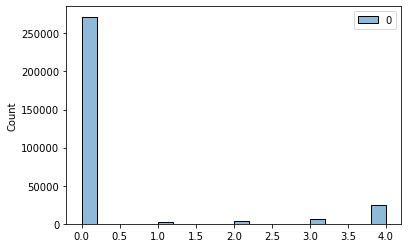

In [23]:
sb.histplot(df)

## 2. Run btrack  

Unite each object with it's subsequent position at the following time point and export as a tracking file. Note that you may need different btrack configurations for different populations.

#### For GFP objects

In [27]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '../models/MDCK_config_wildtype.json'
    )
    tracker.max_search_radius = 40

    # append the objects to be tracked
    tracker.append(objects_gfp)

    # set the volume
    tracker.volume=((0, 1600), (0, 1200), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    gfp_tracks = tracker.tracks

[INFO][2022/03/30 01:46:34 PM] Loaded btrack: /home/nathan/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/03/30 01:46:34 PM] btrack (v0.4.3) library imported
[INFO][2022/03/30 01:46:34 PM] Setting max XYZ search radius to: 100
[INFO][2022/03/30 01:46:34 PM] Starting BayesianTracker session
[INFO][2022/03/30 01:46:34 PM] Loading configuration file: ../models/MDCK_config_wildtype.json
[INFO][2022/03/30 01:46:34 PM] Loading motion model: MDCK_motion
[INFO][2022/03/30 01:46:34 PM] Setting max XYZ search radius to: 40
[INFO][2022/03/30 01:46:34 PM] Objects are of type: <class 'list'>
[INFO][2022/03/30 01:46:35 PM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2022/03/30 01:46:35 PM] Starting tracking... 
[INFO][2022/03/30 01:46:35 PM] Tracking objects in frames 0 to 99 (of 1098)...
[INFO][2022/03/30 01:46:36 PM]  - Timing (Bayesian updates: 12.68ms, Linking: 1.71ms)
[INFO][2022/03/30 01:46:36 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][202

#### For RFP objects

In [30]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '../models/MDCK_config_scribble_sparse.json'
    )
    tracker.max_search_radius = 40

    # append the objects to be tracked
    tracker.append(objects_rfp)

    # set the volume
    tracker.volume=((0, 1200), (0, 1600), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_2')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    rfp_tracks = tracker.tracks

[INFO][2022/03/30 02:39:28 PM] Loaded btrack: /home/nathan/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/03/30 02:39:28 PM] btrack (v0.4.3) library imported
[INFO][2022/03/30 02:39:28 PM] Setting max XYZ search radius to: 100
[INFO][2022/03/30 02:39:28 PM] Starting BayesianTracker session
[INFO][2022/03/30 02:39:28 PM] Loading configuration file: ../models/MDCK_config_scribble_sparse.json
[INFO][2022/03/30 02:39:28 PM] Loading motion model: MDCK_motion
[INFO][2022/03/30 02:39:28 PM] Setting max XYZ search radius to: 40
[INFO][2022/03/30 02:39:28 PM] Objects are of type: <class 'list'>
[INFO][2022/03/30 02:39:28 PM] Set volume to ((0, 1200), (0, 1600), (-100000.0, 100000.0))
[INFO][2022/03/30 02:39:28 PM] Starting tracking... 
[INFO][2022/03/30 02:39:28 PM] Tracking objects in frames 0 to 99 (of 1098)...
[INFO][2022/03/30 02:39:28 PM]  - Timing (Bayesian updates: 0.37ms, Linking: 0.15ms)
[INFO][2022/03/30 02:39:28 PM]  - Probabilities (Link: 1.00000, Lost: 0.99958)
[INF

# 6. Batch process
Iterate over many experiments and positions (need to ensure you define normalisation and classification functions above first)

In [ ]:
root_dir = '/home/nathan/data'
expt_list = ['ND0009', 'ND0010', 'ND0011']
pos_list = 'all'
overwrite = False

for expt in expt_list:
    
        # Find all positions in that experiment, if pos_list is all then it finds all positions
        if pos_list == 'all':
            pos_list = [pos for pos in os.listdir(f'{root_dir}/{expt}') 
                    if 'Pos' in pos 
                    and os.path.isdir(f'{root_dir}/{expt}/{pos}')]  
            
        ### Iterate over all positions in that experiment
        for pos in pos_list:
            
            ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
            if not overwrite and glob.glob(f'{root_dir}/{expt}/{pos}/*tracks*.h5'):
                print(glob.glob(f'{root_dir}/{expt}/{pos}/*tracks*.h5'), f'file found, skipping {expt}/{pos}')
                continue
                
            print(f'Starting {expt}/{pos}')
            # load gfp objects
            with btrack.dataio.HDF5FileHandler(
                 f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_1',
            ) as hdf:
                objects_gfp = hdf.objects
            # load rfp objects
            with btrack.dataio.HDF5FileHandler(
                 f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_1',
            ) as hdf:
                objects_rfp = hdf.objects
            
            # filter objects for non-cell type sizes
            objects_gfp = [o for o in objects_gfp if o.properties['area']>100.]
            objects_rfp = [o for o in objects_rfp if o.properties['area']>100.]
            
            # initialise a tracker session using a context manager for gfp
            with btrack.BayesianTracker() as tracker:

                # configure the tracker using a config file
                tracker.configure_from_file(
                    './models/MDCK_config_wildtype.json'
                )
                tracker.max_search_radius = 40

                # append the objects to be tracked
                tracker.append(objects_gfp)

                # set the volume
                tracker.volume=((0, 1200), (0, 1600), (-1e5, 1e5))

                # track them (in interactive mode)
                tracker.track_interactive(step_size=100)

                # generate hypotheses and run the global optimizer
                tracker.optimize()

                tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_1')

            # initialise a tracker session using a context manager for rfp
            with btrack.BayesianTracker() as tracker:

                # configure the tracker using a config file
                tracker.configure_from_file(
                    './models/.json'
                )
                tracker.max_search_radius = 40

                # append the objects to be tracked
                tracker.append(objects_rfp)

                # set the volume
                tracker.volume=((0, 1200), (0, 1600), (-1e5, 1e5))

                # track them (in interactive mode)
                tracker.track_interactive(step_size=100)

                # generate hypotheses and run the global optimizer
                tracker.optimize()

                tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_2')
                
            print(f'Finished {expt}/{pos}')